Strategy:
1. Create 6 useful features
2. Cross-validate with TimeSeriesSplit (say 10 splits)
3. Scoring with 'roc_auc'
4. GridSearchCV for regularization parameter

## 1. Imports

In [41]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import parfit.parfit as pf
sns.set()

## 2. Helper functions

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
# function to add time features to the data
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    # dayofweek = df['time1'].apply(lambda ts: ts.dayofweek) ## added this myself
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)]) #, dayofweek.values.reshape(-1,1)])
    return X

In [77]:
## parfit stuff
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

## Create logistic regression estimator
logit = LogisticRegression(C=0.16681005, random_state=17, verbose=5) # C = 0.16681005, 0.14677993, 0.21544347 (in order of desc. perf.)
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', logit)])
stoch = SGDClassifier(loss='log', random_state=17, verbose=0, alpha=0.000095)
clf = logit


## Useful CV generators
time_split = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

## 3. Extracting data

    **Load websites dictionary**

In [5]:
with open("../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
#sites_dict.head()

Websites total: 48371


    **Read the training and test data sets, change paths if needed**

In [6]:
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

    **Convert time1...time10 to datetime and organize by time1**

In [7]:
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
# Sort the data by time
train_df = train_df.sort_values(by='time1')

    **Convert site visit data to .txt for CountVectorizer**

In [8]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text2.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text2.txt', 
                                              sep=' ', 
                       index=None, header=None)

    **Set up 'X_train' and 'X_test' sparse matrices**

In [9]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000) # not defining max_features as 50,000 here
with open('train_sessions_text2.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text2.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

## This only puts the sites data into a sparse matrix
## We'll need to add more feature columns later
print('X_train size is: {0} \nX_test size is: {1}'. format(X_train.shape, X_test.shape))

X_train size is: (253561, 50000) 
X_test size is: (82797, 50000)
Wall time: 20 s


    **Create 'y_train' , 'full_df', and 'idx_split' for convenience**

In [10]:
## Train target data is saved separately
y_train = train_df['target'].astype('int')

## full dataset
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# split index
idx_split = train_df.shape[0]

    **Create 'full_time_df'**

In [11]:
full_time_df = pd.DataFrame(index=full_df.index)
# full_time_df['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
# full_time_df['start_day'] = full_df['time1'].apply(lambda ts: ts.day)
# full_time_df['start_month'] = full_df['time1'].apply(lambda ts: ts.month)
full_time_df['start_day_of_week'] = full_df['time1'].apply(lambda ts: ts.dayofweek)
full_time_df['session_mins'] = round((full_df[times].max(axis=1)-full_df[times].min(axis=1))
                                      /np.timedelta64(1, 's')/60, 2)
full_time_df['session_secs'] = round((full_df[times].max(axis=1)-full_df[times].min(axis=1))
                                      /np.timedelta64(1, 's'), 2)

print(full_time_df.shape)
# full_time_df.head()

(336358, 3)


## 4. Create new features

In [12]:
%%time
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)
## Augment X_train and X_test sparse matrices with TOU columns
print('X_train_new size is: {0} \nX_test_new size is: {1}'. format(X_train_new.shape, X_test_new.shape))

X_train_new size is: (253561, 50004) 
X_test_new size is: (82797, 50004)
Wall time: 1.34 s


# PLAYGROUND

  **Helper functions**

In [13]:
# function to add more features
def add_features(new_feat, X_sparse, scale=False):
    if len(new_feat):
        if scale:
            tmp = StandardScaler().fit_transform([new_feat])
        else:
            tmp = new_feat
        X = hstack([X_sparse, tmp.values.reshape(-1, 1)])
    else:
        X = X_sparse
    return X

In [14]:
def try_new_CV(new_feat, X_sparse=X_train_new):
    X_train_new2 = add_features(new_feat, X_sparse)
    cv_scores = cross_val_score(logit, X_train_new2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)
    print('X_train_new2 size is: {0}'. format(X_train_new2.shape))
    return print(cv_scores, cv_scores.mean())

In [ ]:
def update_features(train = X_train_new, test = X_test_new, df = full_df, time_df = full_time_df, train_df = train_df):
    X_new = vstack([train, test]) # combine train and test sets
    
    # day of week feature
    dow = (time_df.start_day_of_week<=1).astype('int')
    
    # session minutes feature
#     s_mins_noScale = time_df.session_mins
#     s_mins = StandardScaler().fit_transform([s_mins_noScale])

    # session secs feature
    s_secs_noScale = time_df.session_mins
    s_secs = StandardScaler().fit_transform([s_secs_noScale])
    
#     alice_topsites = np.array(pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten())
#                               .value_counts().sort_values(ascending=False).head(10).index)
#     top_sites = df.site1.isin(alice_topsites).values.astype('int') #changed df[sites] to df.site1 to see start site
    
    add_feat_noScale = hstack([s_secs_noScale.values.reshape(-1,1),
                               dow.values.reshape(-1,1)])
    add_feat = StandardScaler().fit_transform([add_feat_noScale])
    
    tmp = hstack([X_new, add_feat]).tocsr()
    
#     tmp = hstack([X_new, dow.values.reshape(-1,1), 
#                   s_secs.reshape(-1,1)]).tocsr()
    
    X_train, X_test = tmp[:idx_split,:], tmp[idx_split:,:]
    print('X_train size is: {0} \nX_test size is: {1}'
          .format(X_train.shape,X_test.shape))
    return X_train, X_test
    

 **Updating X_train_new and X_test_new with best new features**  
 Run this every time I make a change to hyperparameters or features

In [43]:
%%time
a,b = update_features() # outputs a= X_train_final, b= X_test_final

X_train size is: (253561, 50006) 
X_test size is: (82797, 50006)
Wall time: 645 ms


In [55]:
# bestModel, bestScore, allModels, allScores = pf.bestFit(stoch, paramGrid, a, y_train, 
#                                                         metric = roc_auc_score, scoreLabel = "AUC")
# print(bestModel, bestScore)

In [78]:
cv_scores = cross_val_score(clf, a, y_train, cv=time_split, verbose=5, 
                            scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.3s finished


[0.86601578 0.74013498 0.92983003 0.97764426 0.91378133 0.95217502
 0.95462947 0.94201774 0.96091949 0.96599528] 0.920314338760018


In [38]:
%%time
clf.fit(a, y_train)

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Wall time: 533 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
logit_test_pred = clf.predict_proba(b)[:, 1]
write_to_submission_file(logit_test_pred, 'km9.csv') 

## km1 = 0.94604
## km2 = 0.94604 (top 5 sites)
## km3 = 0.94604 (first site in top 5 sites)
## km4 = 0.94604 (using GridSearchCV for reg. param.)
## km5 = 0.94992 (removed 'top_sites' & updated C with value from Log.Reg.CV)
## km6 = 0.95021 (using better reg.param.)
## km7 = 0.94953 (using 0.14677993 for C)
## km8 = 0.94953 (replacing sess_mins with sess_secs)
## km9 = 0.94826 (trying SGDClassifier)

**Creating new DFs**

In [16]:
time_df = pd.DataFrame(index=train_df.index)
time_df['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
time_df['start_day'] = train_df['time1'].apply(lambda ts: ts.day)
time_df['start_month'] = train_df['time1'].apply(lambda ts: ts.month)
time_df['start_day_of_week'] = train_df['time1'].apply(lambda ts: ts.dayofweek)
time_df['session_mins'] = round((train_df[times].max(axis=1)-train_df[times].min(axis=1))
                                /np.timedelta64(1, 's')/60, 2)
time_df['session_secs'] = round((train_df[times].max(axis=1)-train_df[times].min(axis=1))
                                /np.timedelta64(1, 's'), 2)

time_df['target'] = train_df['target']

In [17]:
time_df['stop_hour'] = train_df[times].max(axis=1).apply(lambda ts: ts.hour)
time_df.head()

,start_hour,start_day,start_month,start_day_of_week,session_mins,session_secs,target,stop_hour
session_id,,,,,,,,
21669,8,12,1,5,0.00,0.0,0,8
54843,8,12,1,5,29.77,1786.0,0,9
77292,8,12,1,5,0.07,4.0,0,8
114021,8,12,1,5,0.05,3.0,0,8
146670,8,12,1,5,0.03,2.0,0,8


 **Testing on X_train_new**

In [207]:
%%time

feature =[]
try_new_CV(feature)


## TESTED FEATURES:
# 1. (time_df.session_mins<=5).astype('int')
# 2. time_df.start_day_of_week
# 3. (time_df.start_day_of_week<=1).astype('int') -- works!
# 4. ((time_df.start_month>=5) & (time_df.start_month<=10)).astype('int')
# 5. time_df.start_month
# 6. time_df.session_mins -- works!
# 7. time_df.stop_hour



X_train_new2 size is: (253561, 50005)
[0.87707293 0.75150339 0.93051584 0.97861578 0.90397903 0.93828189
 0.96247957 0.92736806 0.94885462 0.9404249 ] 0.9159096013811006
Wall time: 1min 8s


## 5. CV tests

**Run this part for cross-validation:**

In [24]:
%%time
cv_scores = cross_val_score(logit, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[0.8768408  0.74187718 0.93123685 0.97718293 0.91168548 0.94568253
 0.95799311 0.9301223  0.95475983 0.94745043] 0.9174831450116139
Wall time: 32.7 s


**CV scores to beat**

In [97]:
%%time

X_train_final = add_features(feature, a) 
# if features is empty, original X_train_final is returned

print('X_train_final size is: {0}'. format(X_train_final.shape))
cv_scores = cross_val_score(logit, X_train_final, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())
feature = [] # Clears out features to prevent accidental feature addition

X_train_final size is: (253561, 50006)
[0.86601578 0.74013196 0.92982563 0.97764426 0.91378073 0.95217402
 0.95462947 0.94201809 0.96092022 0.96599561] 0.9203135777750443
Wall time: 29.5 s


**Search for best regularization parameter**
Don't run this every time!

In [81]:
c_values = np.logspace(-1, -0.5, 10)

    ~ LogisticRegressionCV ~

In [82]:
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=time_split, verbose=0, n_jobs=-1, scoring='roc_auc')

In [ ]:
%%time
logit_searcher.fit(a, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
logit_searcher.C_ # C = 0.16681005, 0.14677993, 0.21544347 (in order of descending performance)

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

    ~ GridSearch CV ~ Really slow (generalized for non-logistic models)

In [243]:
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [244]:
%%time
logit_grid_searcher.fit(a, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 52.2min finished


Wall time: 52min 20s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1    ,  0.16681,  0.27826,  0.46416,  0.77426,  1.29155,
        2.15443,  3.59381,  5.99484, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [245]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_
## output= (0.9215084569902895, {'C': 0.2782559402207124})

(0.9215084569902895, {'C': 0.2782559402207124})

In [246]:
logit_test_pred_gridcv = logit_grid_searcher.predict_proba(b)[:, 1]
write_to_submission_file(logit_test_pred_gridcv, 'km4.csv') # 0.

    ** Old code **

In [193]:
# alice_topsites = np.array(pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten())
#                       .value_counts().sort_values(ascending=False).head(10).index)

# testSet = alice_topsites = np.array(pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten())
#                       .value_counts().sort_values(ascending=False).head(5).index)

In [205]:
# top_sites = np.sum(train_df[sites].isin(alice_topsites).values, axis=1)

In [30]:
# full_df[sites].head()

In [19]:
# # testing new time features
# def add_time_features2(df, X_sparse):
#     hour = df['time1'].apply(lambda ts: ts.hour)
#     morning = ((hour >= 7) & (hour <= 11)).astype('int')
#     day = ((hour >= 12) & (hour <= 15)).astype('int') ## changed end time from 18 to 15
#     early_evening = ((hour >= 16) & (hour <= 18)).astype('int') ## changed start time from 19 to 16 
#     late_evening = ((hour >= 19) & (hour <= 23)).astype('int') #added this feature
#     night = ((hour >= 0) & (hour <= 6)).astype('int')
#     X = hstack([X_sparse, morning.values.reshape(-1, 1), 
#                 day.values.reshape(-1, 1), early_evening.values.reshape(-1, 1), 
#                 late_evening.values.reshape(-1, 1), night.values.reshape(-1, 1)]) #, dayofweek.values.reshape(-1,1)])
#     return X

In [71]:
#X_test_new2 = add_features(test_df, X_test_new)
## Augment X_train and X_test sparse matrices with TOU columns
# print('X_train_new2 size is: {0} \nX_test_new size2 is: {1}'. format(X_train_new2.shape, X_test_new.shape))

# testfeat = []
# X_train_final2 = add_features(testfeat, X_train_final)
# print('X_train_final size is: {0}'. format(X_train_final.shape))

In [ ]:
# ## Test/Train/Full Sites DataFrames
# train_df_sites = train_df[sites].fillna(0).astype('int')
# test_df_sites = test_df[sites].fillna(0).astype('int')
# full_sites = full_df[sites].fillna(0).astype('int')

####~~~~~~~~~~~
# ## Test/Train/Full Times DataFrames
# train_df_times = train_df[times]
# test_df_times = test_df[times]
# full_times = full_df[times]

####~~~~~~~~~~~~
# ## Train DataFrame for time differences between sessions
# time_df = pd.DataFrame(index=train_df.index)
# time_df['target'] = train_df['target']

# # Find sessions' starting and ending
# time_df['min'] = train_df[times].min(axis=1)
# time_df['max'] = train_df[times].max(axis=1)

# # Calculate sessions' duration in seconds
# time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

####~~~~~~~~~~
# ## Test DataFrame for time differences between sessions
# time_df_test = pd.DataFrame(index=test_df.index)

# # Find sessions' starting and ending
# time_df_test['min'] = test_df[times].min(axis=1)
# time_df_test['max'] = test_df[times].max(axis=1)

# # Calculate sessions' duration in seconds
# time_df_test['seconds'] = (time_df_test['max'] - time_df_test['min']) / np.timedelta64(1, 's')

In [32]:
#type((time_df.session_mins<=10).astype('int'))

pandas.core.series.Series

In [78]:
# maybe = vstack([X_train, X_test])
# maybe[:idx_split, :]

<253561x50000 sparse matrix of type '<class 'numpy.int64'>'
	with 3379553 stored elements in Compressed Sparse Row format>

In [80]:
s_noScale = time_df.session_mins
s_ = StandardScaler().fit_transform([s_noScale])
s_

array([[0., 0., 0., ..., 0., 0., 0.]])

## 6. Plots

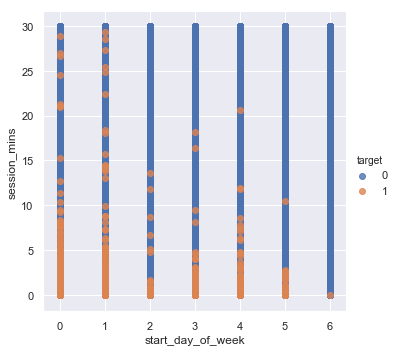

In [27]:
sns.lmplot(x='start_day_of_week', y='session_mins', data=time_df, hue='target', fit_reg=False)

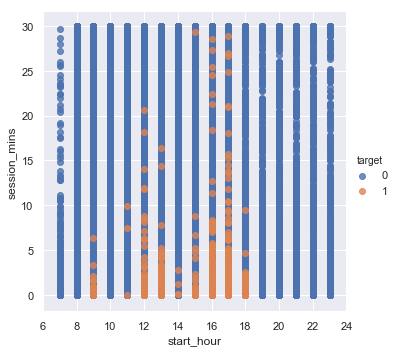

In [40]:
sns.lmplot(x='start_hour', y='session_mins', data=time_df, hue='target', fit_reg=False)

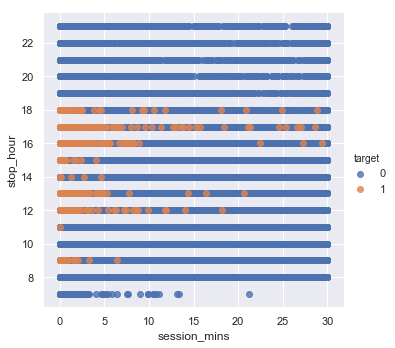

In [167]:
sns.lmplot('session_mins', 'stop_hour', data=time_df, hue='target', fit_reg=False)

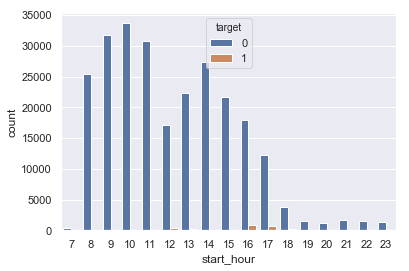

In [171]:
sns.countplot(x='start_hour', data=time_df, hue='target')